In [23]:
import torch
from torchvision import datasets, transforms
import os
import load_model
import eval
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import torchvision.transforms as T
import numpy as np

device = torch.device(f"cuda:0") if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [2]:
def convert_GAL_layers(GAL_model, i):
    features = GAL_model.feature
    cnt = 0
    while cnt <= i:
        if isinstance(features[i], load_model.Mask()):
            i += 1
        cnt += 1
    return i

In [11]:
def get_sparsity_GAL(GAL_model):
    pruned = 0
    num = 0
    pruned_size = 0
    num_size = 0

    for i, (name, param) in enumerate(GAL_model.named_parameters()):
        if 'feature' in name and isinstance(GAL_model.feature[int(name.split('.')[1])], load_model.Mask):
            weight_copy = param.clone()
            param_array = np.array(weight_copy.detach().cpu())
            # print(name, param_array.shape)
            pruned += sum(w == 0 for w in param_array)
            num += len(param_array)
            pruned_size += sum(w == 0 for w in param_array) * param_array.shape[0]
            num_size += len(param_array) * param_array.shape[0]
            # print(sum(w == 0 for w in param_array), len(param_array))
            # print(sum(w == 0 for w in param_array) * param_array.shape[0], len(param_array) * param_array.shape[0] )
            
    print("Pruned {} / {} = {}".format(pruned, num, pruned/num))
    print("Pruned Size {} / {} = {}".format(pruned_size, num_size, pruned_size/num_size))

def get_sparsity_lottery(lottery_jackpot_model):
    pruned = 0
    num = 0
    for layer in lottery_jackpot_model.feature:
        if isinstance(layer, load_model.PretrainConv):
            pruned += torch.sum(layer.b_mask == 0)
            num += torch.numel(layer.b_mask)
    print("Pruned {} / {} = {}".format(pruned, num, pruned/num))

In [4]:
def get10(batch_size, data_root='/tmp/public_dataset/pytorch', train=True, val=True, **kwargs):
    data_root = os.path.expanduser(os.path.join(data_root, 'cifar10-data'))
    num_workers = kwargs.setdefault('num_workers', 1)
    kwargs.pop('input_size', None)
    print("Building CIFAR-10 data loader with {} workers".format(num_workers))
    ds = []
    if train:
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10(
                root=data_root, train=True, download=True,
                transform=transforms.Compose([
                    transforms.Pad(4),
                    transforms.RandomCrop(32),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                ])),
            batch_size=batch_size, shuffle=True, **kwargs)
        ds.append(train_loader)
    if val:
        test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10(
                root=data_root, train=False, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                ])),
            batch_size=batch_size, shuffle=False, **kwargs)
        ds.append(test_loader)
    ds = ds[0] if len(ds) == 1 else ds
    return ds

train_loader, test_loader = get10(batch_size=200, num_workers=1)

Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified
Files already downloaded and verified


In [5]:
pretrain_model = load_model.get_GraSP_VGG('./saved_models/pretrain_best_lottery.pt')
pretrain_model.eval()
print(eval.validate(pretrain_model, test_loader))

Test Loss 0.2991	Accurary 93.79%		Time 6.70s

93.79000091552734


In [6]:
GAL_model = load_model.get_GAL_VGG('./saved_models/gal_best_model-state.pt')
GAL_model.eval()
eval.validate(GAL_model, test_loader)
get_sparsity_GAL(GAL_model)
# Structured Pruning: 0.48 sparsity

Test Loss 0.4720	Accurary 91.89%		Time 5.45s

Pruned 2609 / 5504 = 0.47401889534883723
Pruned Size 1152768 / 2400256 = 0.480268771331058


In [7]:
GraSP_model = load_model.get_GraSP_VGG('./saved_models/grasp_best_model_state.pt')
GraSP_model.eval()
eval.validate(GraSP_model, test_loader)
# 0.9800 sparsity

Test Loss 0.2590	Accurary 92.31%		Time 5.46s



92.30999755859375

In [13]:
lottery_jackpot_model = load_model.get_lottery_VGG('./saved_models/lottery-jackpots-best.pt')
lottery_jackpot_model.eval()
eval.validate(lottery_jackpot_model, test_loader)
get_sparsity_lottery(lottery_jackpot_model)

Test Loss 0.3980	Accurary 90.60%		Time 6.20s

Pruned 18016993 / 20018880 = 0.9000000357627869


In [ ]:
comp_methods = ['cosine', 'l2', 'iou']
comp_results = eval.grad_cam_batch(pretrain_model, lottery_jackpot_model, test_loader, comp_methods=comp_methods, target_layers_x=[pretrain_model.features[27]], target_layers_y=[lottery_jackpot_model.features[27]])
for i in range(len(comp_methods)):
    print(f"{comp_methods[i]}: {comp_results[i]}")

cosine: 0.7408675616693683
l2: 84.79922179776729
iou: 0.37443331919085415


In [17]:
inputs = None
for batch, labels in test_loader:
    inputs = batch
    outputs = labels
    img = batch[0,:,:,:]
    break

In [18]:
def grad_cam_visualization(model, input_tensor=None, target_layers=None):
    if target_layers == None:
        target_layers = [model.features[-14]]
    if input_tensor == None:
        input_tensor = batch # Create an input tensor image for your model..
    # Note: input_tensor can be a batch tensor with several images!

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers)

    # You can also use it within a with statement, to make sure it is freed,
    # In case you need to re-create it inside an outer loop:
    # with GradCAM(model=model, target_layers=target_layers) as cam:
    #   ...

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category
    # will be used for every image in the batch.
    # Here we use ClassifierOutputTarget, but you can define your own custom targets
    # That are, for example, combinations of categories, or specific outputs in a non standard model.

    targets = [ClassifierOutputTarget(outputs[index])]

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    # print(grayscale_cam.min(), grayscale_cam.max(), grayscale_cam.dtype)
    # print(rgb_img.min(), rgb_img.max(), rgb_img.dtype)
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    return visualization


Pretrained Model, Lottery Jackpot Model, GAL Model, GraSP Model
layer: 0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


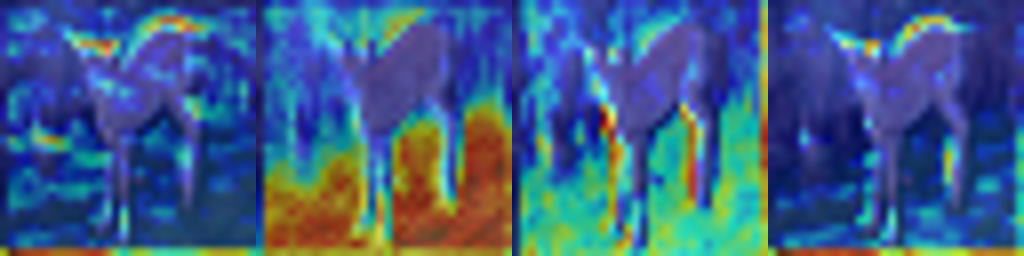

layer: 3 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


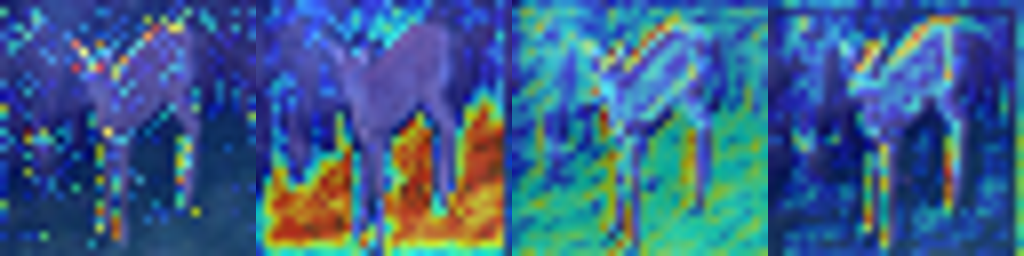

layer: 7 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


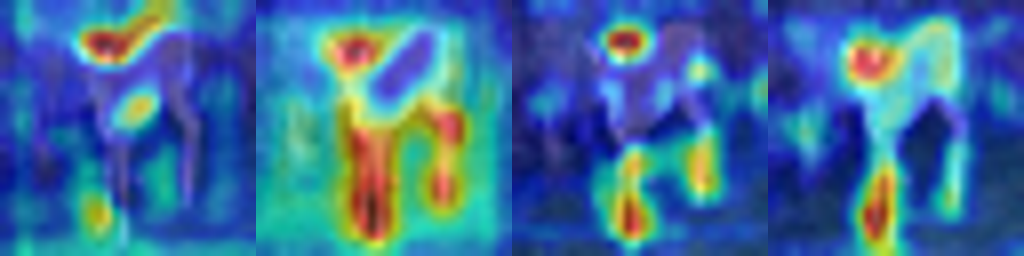

layer: 10 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


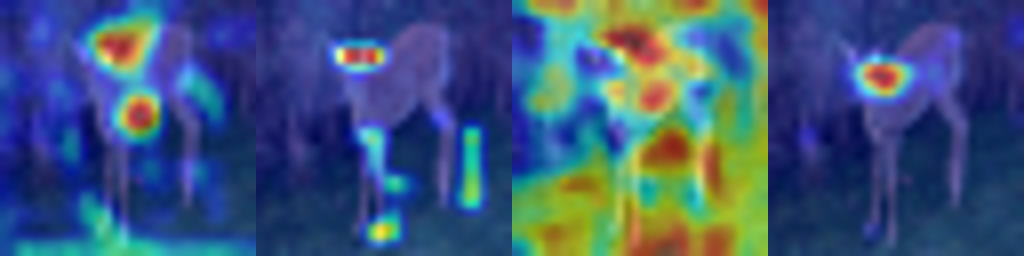

layer: 14 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


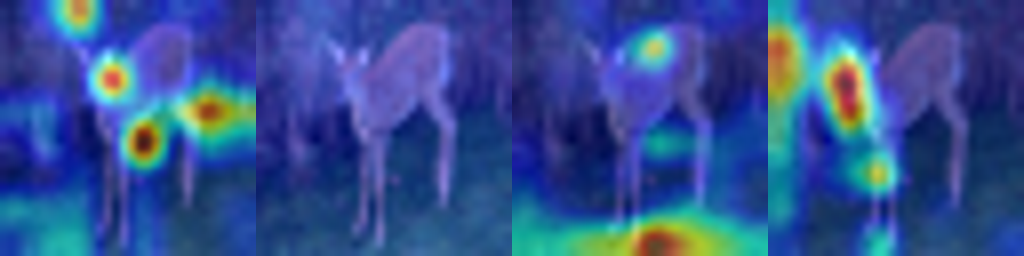

layer: 17 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


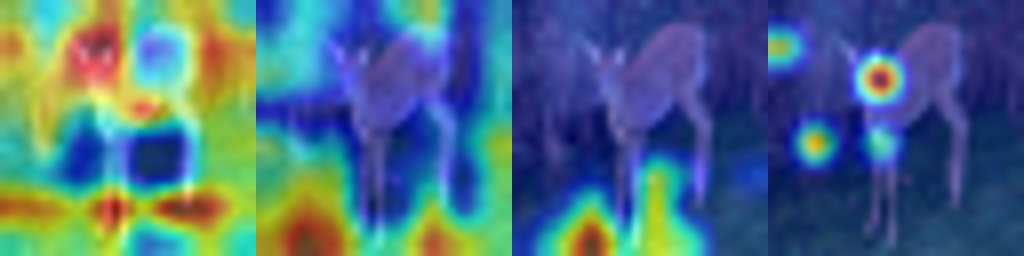

layer: 20 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


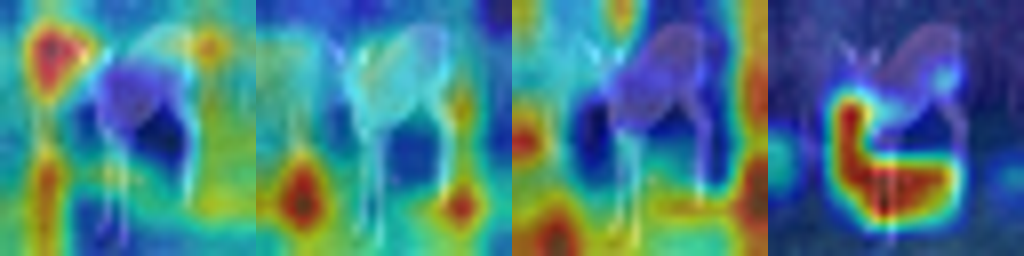

layer: 23 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


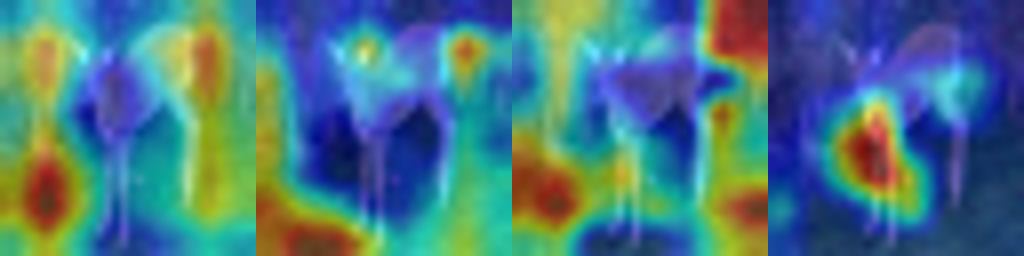

layer: 27 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


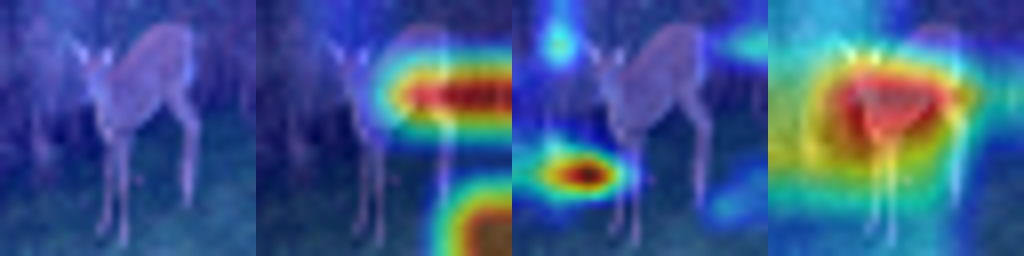

layer: 30 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


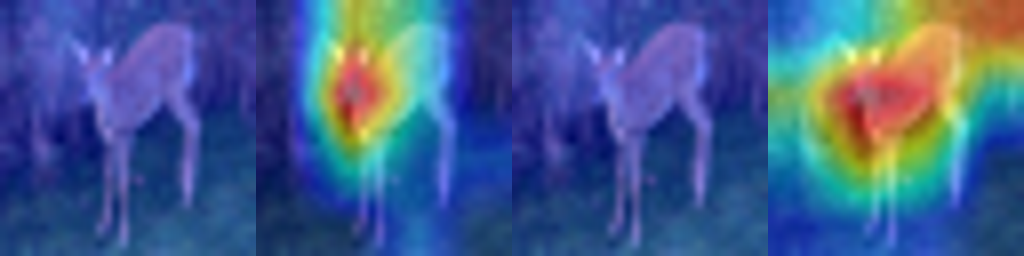

layer: 33 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


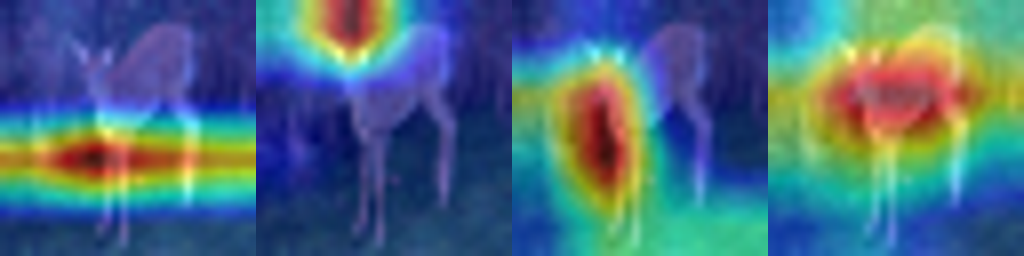

layer: 36 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


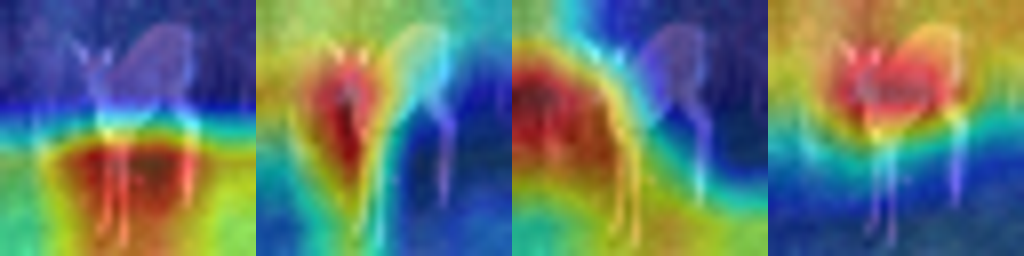

layer: 40 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


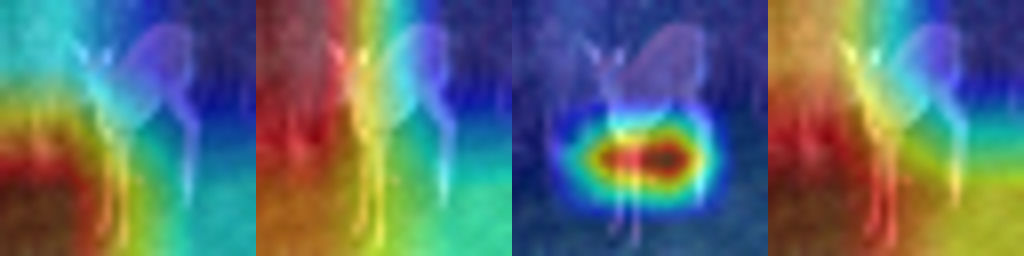

layer: 43 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


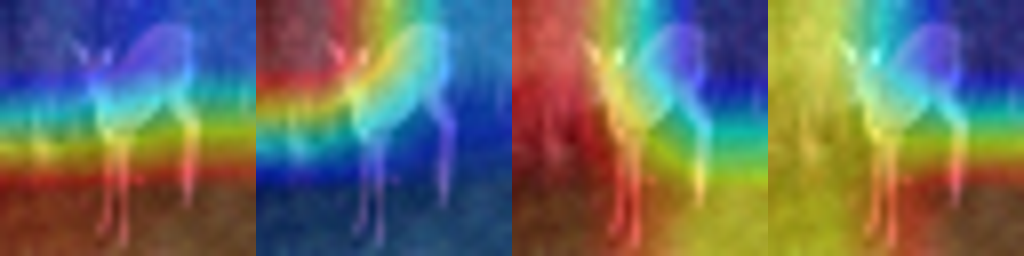

layer: 46 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


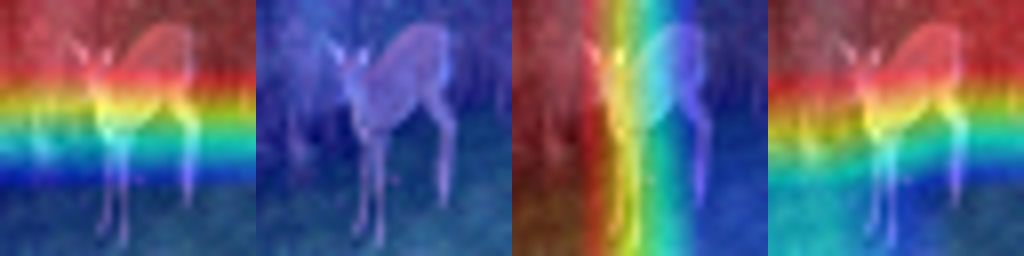

layer: 49 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


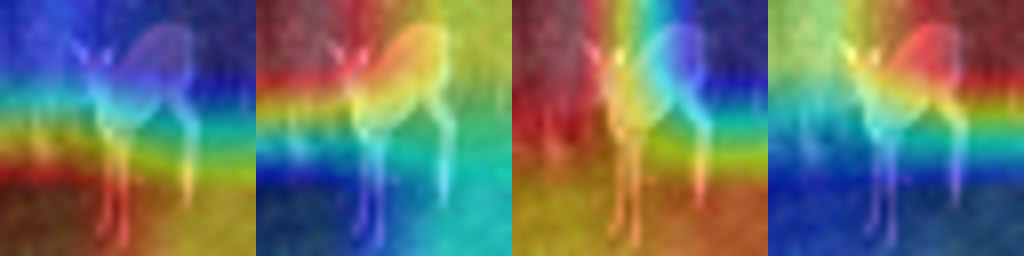

In [27]:
batch = inputs
index = 94
transform = T.ToPILImage()
# print(input[index].min())
rgb_img = np.moveaxis((inputs[index].numpy() + abs(inputs[index].min().item())) / (inputs[index].max().item() + abs(inputs[index].min().item())),0, 2)
rgb_img_pil = Image.fromarray(np.uint8(rgb_img*255))
print("Pretrained Model, Lottery Jackpot Model, GAL Model, GraSP Model")

gal_layer = 0
for i in range(len(pretrain_model.feature)):
    gal_layer += 1 if isinstance(GAL_model.feature[i], load_model.Mask) else 0
    if isinstance(pretrain_model.feature[i], torch.nn.Conv2d):
        print('layer:',i, pretrain_model.feature[i])
        pre_img = Image.fromarray(grad_cam_visualization(pretrain_model, inputs[index][None,:,:,:], target_layers=[pretrain_model.feature[i]])).resize((256,256))
        lottery_img = Image.fromarray(grad_cam_visualization(lottery_jackpot_model, inputs[index][None,:,:,:], target_layers=[lottery_jackpot_model.feature[i]])).resize((256,256))
        GAL_img = Image.fromarray(grad_cam_visualization(GAL_model, inputs[index][None,:,:,:], target_layers=[GAL_model.feature[gal_layer]])).resize((256,256))
        GraSP_img = Image.fromarray(grad_cam_visualization(GraSP_model, inputs[index][None,:,:,:], target_layers=[GraSP_model.feature[i]])).resize((256,256))
        display(Image.fromarray(np.hstack((np.array(pre_img),np.array(lottery_img),np.array(GAL_img),np.array(GraSP_img)))))
    gal_layer += 1